# Machine Learning Nanodegree

### Capstone Project
---

## Stock Price Prediction
This project builds a stock price predictor that examines the historic stock dataset for a publicly listed company and performs learning of various factors that affect the stock and allows prediction of future stock closing values. Predicting time-dependent data, referred to as time-series forecasting, is an active area of research; the task is non-trivial as many factors involved in the prediction: physical factors vs. physhological, rational and irrational behaviour, etc., make share prices volatile and very difficult to predict with a high degree of accuracy.

The share price datasets for publicly listed companies is obtained from [Yahoo Finance](https://finance.yahoo.com/) in [`Part I`](#sec1). In this project, the Linear Regression ([`Part II`](#sec2)) and XGBoost ([`Part III`](#sec3)) methods are used as benchmark models. The performance of an implementation of the Long Short-Term Memory (LSTM) network model ([`Part IV`](#sec4)) is compared for making future predictions.

---

### General Outline
Al the parts of this project will follow this general outline:

1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.

---

### Setup the SageMaker Notebook
Import all the libraries needed for this notebook instance. External libraries listed in [requirements.txt](./requirements.txt) will be installed using `pip`. 

In [1]:
%autosave 60
# import all libraries
import io
import os
import time, requests
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import math
from sklearn.metrics import mean_squared_error

#import support functions from the src/ dir
from src import viz_functions as viz, processData as ppd
from src.lstm.lstm_model import build_lstm_model

#import libraries for S3 and SageMaker
import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

Autosaving every 60 seconds


In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
!pip -q install -r requirements.txt --upgrade --no-cache-dir

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Setup S3 Bucket to Load Data

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

### Setup Working Directories
This project is housed in the following directories:
1. `source_dir`: Is the source directory for this project. 
2. `data_dir`  : This exists inside the `source_dir` and houses the dataset loaded from Yahoo Finance.
3. `processed_data_dir` : This is a sub-directory of the `data_dir` where the processed dataset is stored which will later be used to train/test our machine learning models.
4. `images_dir`: Another directory inside the `source_dir` that is used to store images of plost / figures from this notebook instance.

In [`Part IV`](#sec4) some more directories namely `keras_model` and `export` will be created to that will be used to export a pre-trained model in Keras for depolyment in SageMaker. 

In [4]:
source_dir = '/home/ec2-user/SageMaker/ML_Stock_Price_Prediction' # change this to your main project directory
os.chdir(source_dir)

data_dir = source_dir + '/data/'
processed_data_dir = source_dir +'/data/processedData'
images_dir = source_dir + '/images/'

directories = [data_dir, processed_data_dir, images_dir]

for folders in directories:
    if not os.path.exists(folders):
        os.makedirs(folders)

<a id='sec1'></a>
## I. Get the Data
The share price datasets for publicly listed companies can be obtained from [Yahoo Finance](https://finance.yahoo.com/). To download the datasets from Yahoo Finance we make use of the package [`yfinance`](https://aroussi.com/post/python-yahoo-finance). 

Inputs needed for `yfinance` are: 
1. `symbol`: This is the ticker through which a particular dataset is identified, e.g. `'GOOGL'` for Alphabet Inc. , or `'AAPL'` for Apple Inc.
2. `start` : This is the start date such as `'2009-11-01'` or in Unix Epoch Time
3. `end`   : This is the end date such as `'2019-11-01'` or in Unix Epoch Time

#### 1: Define a helper function 
`get_historical_data()` uses `yfinance` to download the dataset in the `data_dir`

In [5]:
import yfinance as yf

# def get_epoch_time(date):
#     ''' Get the epoch time for a particular date
#         param | date: Date in the format YYYY-MM-DD
#     '''
#     os.environ['TZ']='EST+5ETD'
#     date_time = date + ' 00:00:00'
#     pattern = '%Y-%m-%d %H:%M:%S'
    
#     epoch = int(time.mktime(time.strptime(date_time, pattern)))
#     return epoch

def get_historical_data(symbol,start_date,end_date, data_dir):
    ''' Daily quotes from Google. Date format='yyyy-mm-dd' '''
    symbol = symbol.upper()
    df = yf.download('{0}'.format(symbol), start=start_date, end=end_date)
    df.to_csv(data_dir+'{0}.csv'.format(symbol), index = True, header=False)
    col_names = ['Date','Open','High','Low','Close','Adj_Close','Volume']
    stocks = pd.read_csv('data/{0}.csv'.format(symbol), header=0, names=col_names)
    
    dataFile = pd.DataFrame(stocks)
    return dataFile

#### 2: Get the desired dataset 

In [6]:
# provide the symbol, start, and end date for the dataset to be downloaded
symbol = 'GOOGL'
start  = '2009-11-01'
end    = '2019-11-01'

In [7]:
# from November 1, 2009 to November 1, 2019
data = get_historical_data(symbol, start, end, data_dir)

[*********************100%***********************]  1 of 1 completed


#### 3: Explore the dataset
Use `head()` to get a glimpse of the structure of the dataset downloaded. In the dataset above, we se that there are five coulumns:
* `Date`  : The date when the stock prices were recorded
* `Open`  : The opening proce of the stock on that day
* `High`  : The recorded high price of the stock on that day
* `Low`   : The recorded low price of the stock on that day
* `Close` : The closing price of the stock that day
* `Adj_Close`: The adjusted closed price of the stock that day
* `Volume`: The volume of transactions that day

To variation in the dataset can be understood by exploring the mean, standard deviation, max and min values, etc. Use the `describe()` attribute that  lists this information for a given dataset. 

In [8]:
data.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2009-11-03,265.270264,269.019012,264.414429,268.913910,268.913910,4755600
1,2009-11-04,270.670685,273.023010,268.478485,270.435425,270.435425,4660700
2,2009-11-05,272.017029,275.160156,271.601593,274.599609,274.599609,3691700
3,2009-11-06,274.134125,276.166168,273.023010,275.825836,275.825836,3649700
4,2009-11-09,278.002991,281.571564,277.392395,281.536530,281.536530,5294500


In [9]:
data.describe()

,Open,High,Low,Close,Adj_Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,635.397300,640.689145,629.668080,635.334439,635.334439,3.427869e+06
std,320.135523,322.995625,317.249482,320.265958,320.265958,2.672654e+06
min,219.374374,221.361359,217.032028,218.253250,218.253250,5.206000e+05
25%,311.961975,314.191681,310.307800,312.367371,312.367371,1.583525e+06
50%,561.025024,565.725006,556.744995,561.229980,561.229980,2.561600e+06
75%,924.400009,934.392487,919.444992,924.935013,924.935013,4.489575e+06
max,1289.119995,1299.239990,1272.310059,1296.199951,1296.199951,2.961990e+07


#### 4: Feature selection
As we can see from the `describe()` attribute for the dataset downloaded, the number of enteries are listed in the **count**. Additionally, for this basic implementation of the stock price predictor we will drop the `High` and `Low` values and only work with only three features: `Open`, `Close` and `Volume` part of the dataset.

**[NOTE]**: The dataset is already arranged in the ascending order when loaded from Yahoo Finance, and thus, these dates are replaced with `Item` number.

Remove the `Date`, `High` and `Low` values using the helper function `remove_data()` from [processData.py](./src/processData.py)

In [10]:
stocks = ppd.remove_data(data)

#Print the dataframe head and tail
print(stocks.head())
print("---")
print(stocks.tail())

   Item        Open       Close   Volume
0     0  265.270264  268.913910  4755600
1     1  270.670685  270.435425  4660700
2     2  272.017029  274.599609  3691700
3     3  274.134125  275.825836  3649700
4     4  278.002991  281.536530  5294500
---
      Item         Open        Close   Volume
2511  2511  1252.000000  1264.300049  1355200
2512  2512  1275.000000  1288.979980  3271400
2513  2513  1276.000000  1260.660034  2632700
2514  2514  1255.150024  1260.699951  1460200
2515  2515  1260.000000  1258.800049  1595000


#### 5: Visualize the dataset
Use the helper functions for plotting and saving figures in `image_dir` from [viz_functions.py](./src/viz_functions.py)

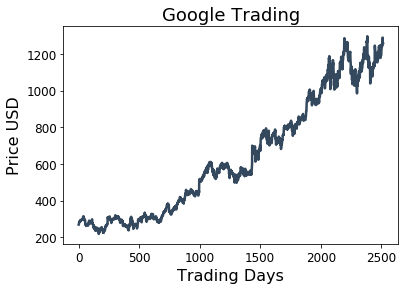

In [11]:
viz.plot_basic(stocks, filename = images_dir+'basic.png')

#### 6: Normalize the dataset and visualize
Use the `MinMaxScaler` function encoded in [processData.py](./src/processData.py) to normalize the dataset values between `0` and `1` to facilitate training and testing.

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


   Item      Open     Close    Volume
0     0  0.042904  0.046997  0.145536
1     1  0.047952  0.048409  0.142275
2     2  0.049210  0.052272  0.108975
3     3  0.051190  0.053409  0.107532
4     4  0.054806  0.058707  0.164055


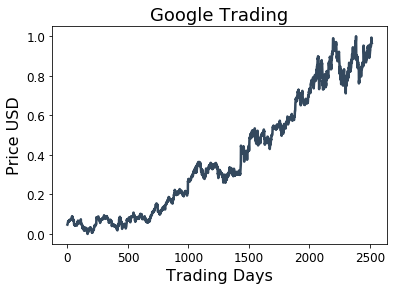

In [12]:
stocks = ppd.normalise_data(stocks)
print(stocks.head())

#visualize the normalized dataset
viz.plot_basic(stocks, filename = images_dir+'normalized.png')

#### 7: Save the processed dataset
Log the processed, normalized and cleaned dataset as a `csv` file in the `processed_data_dir` for future reusability. 

In [13]:
stocks.to_csv(processed_data_dir + '/{0}_processed.csv'.format(symbol) ,index= False, header=True)

---

<a id='sec2'></a>
## II. Benchmark : Linear Regression 
The stock price datasets form a time-series dataset. From the visualizations seen in the data exploration part, we have seen how the closing price of the stock varies with time (trading days). Therefore, predicting stock prices can be thought of as a linear regression problem. For the given input dataset $(\mathbf{X}, y)$ where $\mathbf{X}$ is a high-dimensional vector and $y$ is a numeric label, or in this case, a real number denoting the price of the stock. 

If we set $y$ or the `target` to be `Close` price of the stock that needs to be predicted, and choose the `Item`, `Open` and `Volume` as $\mathbf{X}$ which forms the set of input features, then the linear algorithm learns a linear function and maps $\mathbf{X}$ to an approximation of the label $y$,

\begin{equation*}
\displaystyle \widetilde{y} = \theta_1 X_1 + \theta_2 X_2 + \theta_3 X_3
\end{equation*}

The Amazon SageMaker linear learner algorithm provides a solution for both classification and regression problems. More details can be found [here](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html).

#### 1: Setup the built-in LinearLearner model in SageMaker

In [14]:
# import LinearLearner
from sagemaker import LinearLearner

# specify an output path
prefix = 'stockPrices'
output_path = 's3://{}/{}/output'.format(bucket, prefix)

# instantiate LinearLearner
linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='regressor',
                       loss='squared_loss',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=15)

#### 2: Load the processed dataset
Load the already pre-processed and saved dataset from `processed_data_dir`. 

In [15]:
stocks = pd.read_csv(processed_data_dir + '/{0}_processed.csv'.format(symbol))
display(stocks.head())

,Item,Open,Close,Volume
0,0,0.042904,0.046997,0.145536
1,1,0.047952,0.048409,0.142275
2,2,0.049210,0.052272,0.108975
3,3,0.051190,0.053409,0.107532
4,4,0.054806,0.058707,0.164055


#### 3: Split the dataset
Split the dataset into `train` and `test` sets using the `train_test_split()` helper function from [processedData.py](./src/processData.py). Prescribe: 
* `train_fraction`: the fraction of the dataset to be used for training. A numeric value between `0` and `1`.


**[NOTE]**: The dataset in parctice should also be split up into a validation set, that can be used to evaluate the model parameters and tune any hyperparameters if needed. This process is skipped here. 

In [16]:
# The 80/20 split to train/test the LinearLearner model
train_fraction = 0.8
X_train, X_test, y_train, y_test = ppd.train_test_split(stocks, train_fraction)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (2012, 3)
y_train (2012,)
x_test (504, 3)
y_test (504,)


/home/ec2-user/SageMaker/ML_Stock_Price_Prediction/src/processData.py:107: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  stock_matrix = stocks.as_matrix()


#### 4: Fromat the dataset for training
The Amazon SageMaker LinearLearner model requires the training dataset to be a `Recordset` object. This is done through the `linear.record_set()` that constructs a `RecordSet` object from **ndarray** arrays. In addition, convert the `train` and `test` datasets from `float64` to `float32` format for `record_set()` to work properly. For more details on `Recordset` visit this [page](https://sagemaker.readthedocs.io/en/stable/linear_learner.html#sagemaker.LinearLearner.record_set).

In [17]:
# convert features/labels to numpy in float32 format
train_x_np = X_train.astype('float32')
train_y_np = y_train.astype('float32')

test_x_np = X_test.astype('float32')
test_y_np = y_test.astype('float32')

# create RecordSet
formatted_train_data = linear.record_set(train_x_np , labels=train_y_np)

#### 5: Train the linear estimator
Train the `linear` estimator on the formatted training data created as a `Recordset`. This creates a training job that can be monitored in the SageMaker console. Use the `%%time` directive to see the total time taken to execute the training and the actual billable time given by SageMaker.

In [18]:
%%time 
# train the estimator on formatted training data
linear.fit(formatted_train_data)

2019-11-28 22:05:11 Starting - Starting the training job...
2019-11-28 22:05:12 Starting - Launching requested ML instances......
2019-11-28 22:06:34 Starting - Preparing the instances for training......
2019-11-28 22:07:14 Downloading - Downloading input data...
2019-11-28 22:08:09 Training - Training image download completed. Training in progress.
2019-11-28 22:08:09 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
[11/28/2019 22:08:06 INFO 140085482997568] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step'


2019-11-28 22:08:16 Completed - Training job completed
Training seconds: 62
Billable seconds: 62
CPU times: user 476 ms, sys: 40.6 ms, total: 517 ms
Wall time: 3min 42s


#### 6: Deploy the trained model
Deploying the trained model to create a `linear_predictor`. We use the `model.deploy()`, which takes the following two arguments: 
* `initial_instance_count` : The number of deployed instances - here its `1`.
* `instance_type`          : The type of SageMaker instance for deployment - here `ml.t2.medium` are used.

In [19]:
%%time 
# deploy and create a predictor
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------------------------------------------------------------------------------------------------------------!CPU times: user 520 ms, sys: 40 ms, total: 560 ms
Wall time: 9min 9s


#### 7: Evaluate the deployed model
The performance of the delpoyed model can be evaluated against the `test` data. The `linear_predictor` expects an **ndarray** of input features and returns a list of Records. See [predictor documentation](https://sagemaker.readthedocs.io/en/stable/linear_learner.html#sagemaker.LinearLearnerPredictor) for details.

First test linear model on just one test point, to see the resulting list.

In [20]:
# test one prediction
result = linear_predictor.predict(test_x_np[0])

print (result)

[label {
  key: "score"
  value {
    float32_tensor {
      values: 0.7172136902809143
    }
  }
}
]


#### Helper function for evaluation
The provided function below, takes in a deployed predictor, some test features and labels, and returns a metric score of `mean_squared_error()` between the predictions ($\tilde{y}$) and the actual values ($y$).

\begin{align*}
\displaystyle MSE &= \frac{1}{n}\sum\limits_{i=1}^n (y_i - \tilde{y_i})^2 \\
\displaystyle RMSE &= (\frac{1}{n}\sum\limits_{i=1}^n (y_i - \tilde{y_i})^2)^{1/2} = \sqrt{MSE}
\end{align*}

In [21]:
from sklearn.metrics import mean_squared_error
import math

# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['score'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    viz.plot_prediction(test_labels, test_preds, filename = images_dir+'linearModel.png')

    #calculate the score based on mean squared error
    score = mean_squared_error(test_preds, test_labels)
    
    # printing a table of metrics
    if verbose:
        print("{:<11} {:.8f} MSE ({:.8f} RMSE)".format('Score:', score, math.sqrt(score)))
        print()
        
    return {'Predictions': test_preds, 'Score': score}

Metrics for simple, LinearLearner.

Score:      0.00276604 MSE (0.05259319 RMSE)



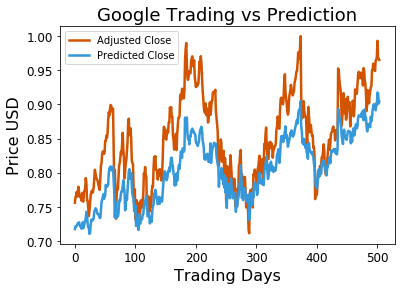

In [22]:
print('Metrics for simple, LinearLearner.\n')

# get metrics for linear predictor
predictions, metrics = evaluate(linear_predictor, 
                   test_x_np, 
                   test_y_np, 
                   verbose=True) # verbose means we'll print out the metrics

#### 8: Delete the Endpoint
A convenience function to delete prediction endpoints. After model evaluation, the model endpoint must be deleted!

In [23]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [24]:
# delete the predictor endpoint 
delete_endpoint(linear_predictor)

Deleted linear-learner-2019-11-28-22-05-11-012


---
<a id='sec3'></a>
## III. Benchmark : XGBoost
Another popular technique for linear regression relies on [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) method that produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion, and it generalizes them by allowing optimization of an arbitrary differentiable loss function. Say for instance that the goal is to "teach" a model $\mathcal{F}$ to predict values of the form $\displaystyle \widetilde{y} = \mathcal{F}(x)$. 

At each stage $m$, $1 \leq m \leq M$, of gradient boosting, it may be assumed that there is some imperfect model $\mathcal{F}_m$.  The gradient boosting algorithm improves on $\mathcal{F}_m$ by constructing a new model that adds an estimator $h$ to provide a better model. To find $h$, the gradient boosting solution starts with the observation that a perfect $h$ would imply: 

\begin{equation*}
\mathcal{F}_{m+1} (x) = \mathcal{F}_m (x) + h (x) = y
\end{equation*}

or equivalently, 

\begin{equation*}
h (x) = y - \mathcal{F}_m (x)
\end{equation*}

Therefore, gradient boosting will fit $h$ to the residual $ y - \mathcal{F}_m (x)$. 

XGBoost is an optimized distributed gradient boosting library designed to be highly **efficient, flexible** and **portable**. <br>
It implements machine learning algorithms under the Gradient Boosting framework. Check this [github page](https://github.com/dmlc/xgboost) for more details.

Amazon SageMaker provides an in-built algorithm for [XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html).

In [25]:
# import libraries needed for XGBoost 
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

#### 1: Load the processed dataset
Load the already pre-processed and saved dataset from `processed_data_dir`.

In [26]:
stocks = pd.read_csv(processed_data_dir + '/{0}_processed.csv'.format(symbol))
display(stocks.head())

,Item,Open,Close,Volume
0,0,0.042904,0.046997,0.145536
1,1,0.047952,0.048409,0.142275
2,2,0.049210,0.052272,0.108975
3,3,0.051190,0.053409,0.107532
4,4,0.054806,0.058707,0.164055


#### 2: Split the dataset
Using the `train_test_split()` helper function from [processedData.py](./src/processedData.py), split the dateset into:
* `train`: The part of the dataset that will be used to train the estimator.
* `val`  : The part of the dataset that will be used to evaluate the estimator and tune hyperparameters.
* `test` : The part of the dataset that will be used to check the performance of the deployed model.

Here the dataset is first split into `80/20` `train` and `test` respectively. <br>Then, the `train` data is again split  such that `20%` corresponds to validation (`val`). 

In [27]:
# The 80/20 split to train/test the XGBoost model
# Further split the training set such that 20% comprises of validation data.
train_fraction = 0.8
val_fraction = 0.2

X_train, X_val, X_test, y_train, y_val, y_test = ppd.train_test_split(stocks, 
                                                                      train_fraction, 
                                                                      val_frac=val_fraction)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_validation", X_val.shape)
print("y_validation", y_val.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (1610, 3)
y_train (1610,)
x_validation (402, 3)
y_validation (402,)
x_test (504, 3)
y_test (504,)


/home/ec2-user/SageMaker/ML_Stock_Price_Prediction/src/processData.py:107: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  stock_matrix = stocks.as_matrix()


#### 3: Save the data
Using pandas to save test, train and validation data to `csv` files. Note that header information or an index as this is not included as required by the built in algorithms provided by Amazon. Also, for the train and validation data, it is assumed that the first entry in each row is the target variable. <br>
These files will then be uploaded to S3

In [28]:
# save files locally as csv

X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
X_test.to_csv(os.path.join(processed_data_dir, 'XGB_features_test.csv'), header=False, index=False)
y_test.to_csv(os.path.join(processed_data_dir, 'XGB_labels_test.csv'), header=False, index=False)

pd.concat([pd.DataFrame(y_val), pd.DataFrame(X_val)], axis=1).to_csv(os.path.join(processed_data_dir, 'XGB_validation.csv'), header=False, index=False)
pd.concat([pd.DataFrame(y_train), pd.DataFrame(X_train)], axis=1).to_csv(os.path.join(processed_data_dir, 'XGB_train.csv'), header=False, index=False)

#### Upload to S3
Use the SageMaker session object to upload data to the 'default' S3 bucket with a custom prefix (S3 folder).

In [29]:
prefix = 'stockPrices-xgboost'
output_path = 's3://{}/{}/output'.format(bucket, prefix)

test_location = sagemaker_session.upload_data(os.path.join(processed_data_dir, 'XGB_features_test.csv'), key_prefix=prefix)
val_location = sagemaker_session.upload_data(os.path.join(processed_data_dir, 'XGB_validation.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(processed_data_dir, 'XGB_train.csv'), key_prefix=prefix)

#### 4: Setup the built-in XGBoost estimator
Constructing the XGBoost model and train it with the training and validation data that was uploaded to S3. Here a high-level SageMaker API is used which will make the resulting code a little easier to read. 

Since a built-in algorithm is used, it is required to provide the location of the container that contains the training code. This container is provided by Amazon. SageMaker provides a useful utility method called `get_image_uri` that constructs the required container image name.

In [30]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container,     # The name of the training container
                                    role = role,             # The IAM role to use (our current role in this case)
                                    train_instance_count=1,  # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path= output_path,  # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

Before beginning the training, some model specific hyperparameters must be set. XGBoost algorithm has quite a few hyperparameters. <br>
Complete list can be found at [XGBoost hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html). Guide to [parameter tuning](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) in XGBoost directs how to set the parameters here. 

In [31]:
xgb.set_hyperparameters(max_depth=5,       # Higher depth will allow model to learn relations, typically 3-10
                        eta=0.2,           # Typical final values to be used: 0.01-0.2
                        gamma=4,           # Makes the algorithm conservative.
                        alpha=0,           # Can be used for very high dimensionality to run the algorithm faster
                        min_child_weight=6,# Higher values prevent a model from learning relations
                        subsample=0.8,     # Lower values make the algorithm more conservative, typically 0.5-1 
                        objective='reg:linear', # reg:squarederror is favored instead of reg:linear
                        early_stopping_rounds=10,
                        num_round=200)

Create a hyperparameter tuner. Here the following parameters are tuned `max_depth`, `eta`, `min_child_weight`, `subsample` and `gamma`. Around 20 models are chosen to be trained below, of which SageMaker will train 3 in parallel (This can take some time ~ 25 mins). 

**[NOTE]** These steps are optional, and are carried out with the Batch Transform functionality. Once the model is ready and tested, it will be deployed. 

In [32]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:rmse', # The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

#### 5: Train the XGBoost estimator
Train the XGBoost estimator with the training and validation data stored in S3. It is ensured that SageMaker knows that our data is in `csv` format through a wrapper, which is then fed to the `fit` method. 

In [33]:
%%time
# This is a wrapper around the location of our train and validation data, 
# to make sure that SageMaker knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

CPU times: user 14.6 ms, sys: 0 ns, total: 14.6 ms
Wall time: 342 ms


In [34]:
%%time
xgb_hyperparameter_tuner.wait()

..............................................................................................................................................................................................................................................................................!
CPU times: user 1.41 s, sys: 55.7 ms, total: 1.47 s
Wall time: 22min 42s


Retrieve the information about the best performing model

In [35]:
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-191128-2221-018-25848f47'

Construct a new estimator object from the results of the best training job. The `xgb_attached` object below can now be used as though it were an estimator with the best performing hyperparameters and then fit it to our training data.

In [36]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2019-11-28 22:41:01 Starting - Preparing the instances for training
2019-11-28 22:41:01 Downloading - Downloading input data
2019-11-28 22:41:01 Training - Training image download completed. Training in progress.
2019-11-28 22:41:01 Uploading - Uploading generated training model
2019-11-28 22:41:01 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[22:40:51] 1

#### 6: Test the trained model using Batch Transform (Optional)
The trained and validated model is tested with SageMaker's Batch Transform functionality.
1. Build a transformer object from our fit model.
2. Ask SageMaker to begin a batch transform job using the trained model and applying it to the test data which was previously stored in S3.
3. Store the resulting output in S3. Save this data locally to analyze.
4. Create a simple plot between the predicted and actual values to see how the model performs.

**[NOTE]**: Once the model is ready to be deployed, skip these steps as the deployed model will be evaluated later.

In [ ]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [ ]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [ ]:
xgb_transformer.wait()

In [ ]:
!aws s3 cp --recursive $xgb_transformer.output_path $processed_data_dir

In [ ]:
Y_pred = pd.read_csv(os.path.join(processed_data_dir, 'XGB_features_test.csv.out'), header=None)

In [ ]:
viz.plot_prediction(y_test, Y_pred, filename = images_dir+'xgbTransform.png')

from sklearn.metrics import mean_squared_error
import math

score = mean_squared_error(y_test, Y_pred)
print("{:<11} {:.8f} MSE ({:.8f} RMSE)".format('Score:', score, math.sqrt(score)))

#### 7: Deploy the trained model
Now that the model is fit to the training data, using the validation data to avoid overfitting, it can be deployed and tested. A high-level API is used, similar to the `LinearLearner` case, where the `model.deploy()` method is used. 

In [37]:
%%time
xgb_predictor = xgb_attached.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

--------------------------------------------------------------------------------------------------!CPU times: user 493 ms, sys: 20.7 ms, total: 513 ms
Wall time: 8min 14s


#### 8: Evaluate the model
Once the model is trained and deployed, test data can be sent to it to evaluate the results and its performance. Here, since the test data is small, we can send it all using a single call to the endpoint. If the test dataset was larger it'd have to be split up and sent in chunks, making sure to accumulate the results. To see how the model performs, create a visual plot between the predicted and actual values. 

In [38]:
# We need to tell the endpoint what format the data we are sending is in
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

# predictions = xgb_predictor.predict(X_test)
predictions = xgb_predictor.predict(X_test.values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up
# as a numpy array.
predictions = np.fromstring(predictions, sep=',')
predictions = pd.DataFrame(predictions)

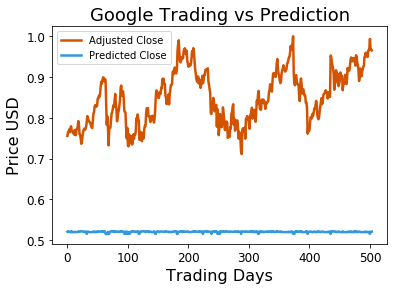

In [39]:
viz.plot_prediction(y_test, predictions, filename = images_dir+'xgbDeployed.png')

A more quantitative metric of performance is the `mean_squared_error` between the predictions ($\tilde{y}$) and the actual values ($y$).

\begin{align*}
\displaystyle MSE &= \frac{1}{n}\sum\limits_{i=1}^n (y_i - \tilde{y_i})^2 \\
\displaystyle RMSE &= (\frac{1}{n}\sum\limits_{i=1}^n (y_i - \tilde{y_i})^2)^{1/2} = \sqrt{MSE}
\end{align*}

In [40]:
score = mean_squared_error(y_test, predictions)
print("{:<11} {:.8f} MSE ({:.8f} RMSE)".format('Score:', score, math.sqrt(score)))

Score:      0.11284369 MSE (0.33592215 RMSE)


#### 9: Delete the endpoint

In [41]:
# delete the predictor endpoint 
delete_endpoint(xgb_predictor)

Deleted sagemaker-xgboost-191128-2221-018-25848f47


---
<a id='sec4'></a>
## IV. Long Short-Term Memory (LSTM) Networks

Long Short-Term Memory (LSTM) networks are a kind of recurrent neural network (RNN) that are capable of learning long-term dependencies. The respeating modules of the standard RNN have a simple structure, such as a single tanh layer. However, the repeating modules in a LSTM have a different design with four layers interacting in a special way. The key to LSTMs is the cell state $\mathcal{C}_t$. The LSTMs have the ability to remove or add information to the cell state, regulated by structures called gates. Gates are a way to optionally let information through. They are composed out of a sigmoid neural net layer and a pointwise multiplication operation. The sigmoid layer outputs numbers between `0` which means **let nothing through** and `1` that means **let everything through!**.
The three important gates are:

* `Forget Gate Layer`: Decides what information to throw away from the cell state. It looks at the output from previous cell $h_{t-1}$ and some input to current cell $x_t$, and outputs a number between 0 and 1. The operation can be defined as, 

\begin{equation*}
\displaystyle f_t = \sigma(W_f.[h_{t-1}, \,x_t] + b_f)
\end{equation*}

* `Input Gate Layer`: Decides what new information to store in the cell state. First, a sigmoid layer decides which values we’ll update. Next, a tanh layer creates a vector of new candidate values, that could be added to the state. To update the old cell state, $\mathcal{C}_{t−1}$, into the new cell state $\mathcal{C}_t$, multiply the old state by $f_t$ forgetting the things as decided earlier. Then, add the new input $i * \widetilde{\mathcal{C}}_t$ scaled by how much to update each state value. Thus, new state $\mathcal{C}_t$ is given by, 

\begin{equation*}
\displaystyle \mathcal{C}_t = f_t * \mathcal{C}_{t−1} + i * \widetilde{\mathcal{C}}_t
\end{equation*}

where $i_t = \sigma(W_i.[h_{t-1}, \,x_t] + b_i)$, and $\widetilde{\mathcal{C}}_t = \tanh(W_{\mathcal{C}}.[h_{t-1}, \,x_t] + b_{\mathcal{C}})$.

* `Output Gate Layer`: Decides what to output. This output is based on the cell state, but will be a filtered version. First, a sigmoid layer decides what parts of the cell state to output. Then, the cell state is put through tanh (to push the values to be between −1−1 and 11) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided to.

\begin{align*}
\displaystyle o_t &= \sigma(W_o.[h_{t-1}, \,x_t] + b_o) \\
h_t &= o_t*tanh(\mathcal{C}_t)
\end{align*}

A more detailed desription and discussion of LSTM is provided in [Colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) or read the original [paper](http://www.bioinf.jku.at/publications/older/2604.pdf).

---

### Using LSTMs for Stock Price Prediction
From the above two benchmark models [`LinearLearner`](#sec2) and [`XGBoost`](#sec3) it was observed that training the model can be hard. While it appears that for linear regression, the date (or Item) and the closing price is sufficient to train the model. LinearLearner even performs well. However, Stocks are heavily affected by many factors that are not documented, such as brand value, policies and political environments, news and other events. Thus statistcal regression alone cannot yield accurate predictions for stock prices. However, advanced machine learning techniques such as LSTMs that specialize in learning long-term dependencies can be good candidates for time-seris data prediction. 

Here we showcase an implementation of the LSTM using `Keras` in SageMaker with `TensorFlow` to train and predict the closing price from our dataset.

---

#### 1: Load the processed dataset
Load the already pre-processed and saved dataset from `processed_data_dir`.

In [42]:
stocks = pd.read_csv(processed_data_dir + '/{0}_processed.csv'.format(symbol))
display(stocks.head())

,Item,Open,Close,Volume
0,0,0.042904,0.046997,0.145536
1,1,0.047952,0.048409,0.142275
2,2,0.049210,0.052272,0.108975
3,3,0.051190,0.053409,0.107532
4,4,0.054806,0.058707,0.164055


#### 2: Split the dataset
Similar to the [`XGBoost`](#sec3) case, split the dataset into `train`, `val` and `test` data. <br>
The input to the LSTM is a 3D tensor defined as (`batch_size`, `time_steps`, `num_features`). 
* `batch_size`: Equivalent to number of samples, defines how many samples will be input to the network at a time. For large datasets, it is recommended that the input be divided and fed to the network as chunks.
* `time_steps`: How many time steps of the data are send to the network in a single batch. The network looks and learns from the historic data at these time steps with each sample. Generally a good pratice to keep time_step size in the range 200-400. This is provided here as **history_size**.
* `num_features`: The number of features used for training the network. Here, all the columns except for ['Item'] will be used, and thus ['Open', 'Close', 'Volume'] gives **3 features**. 

In [43]:
# The 80/20 split to train/test the XGBoost model
# Further split the training set such that 20% comprises of validation data.
train_fraction = 0.8
val_fraction = 0.2

# Providing other information to create datasets for LSTMs 
num_features = 3     # Using all 3 features, 
history_size = 200   # Using 200 time-steps in each batch,
target_size  = 14    # No. of days to predict in future,

X_train, X_val, X_test, y_train, y_val, y_test = ppd.create_dataset_lstm(stocks, 
                                                                         train_frac=train_fraction, 
                                                                         history_size=history_size, 
                                                                         target_size=target_size,
                                                                         val_frac=val_fraction)

#rehaping the datasets to ensure format (batch_size, time_steps, num_features)
X_train = X_train.reshape((-1, history_size, num_features))
y_train = y_train.reshape((-1, target_size))

X_val = X_val.reshape((-1, history_size, num_features))
y_val = y_val.reshape((-1, target_size))

X_test = X_test.reshape((-1, history_size, num_features))
y_test = y_test.reshape((-1, target_size))

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_validation", X_val.shape)
print("y_validation", y_val.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (1396, 200, 3)
y_train (1396, 14)
x_validation (188, 200, 3)
y_validation (188, 14)
x_test (290, 200, 3)
y_test (290, 14)


/home/ec2-user/SageMaker/ML_Stock_Price_Prediction/src/processData.py:107: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  stock_matrix = stocks.as_matrix()


#### 3: Build and setup the LSTM model
Use the LSTM model definition in [lstm_model.py](./src/lstm/lstm_model.py) to build and setup the LSTM model. SageMaker implements a wrapper of TensorFlow which enables training, building, deployment and monitoring of TensorFlow models. This implementation uses a high-end API of TensorFlow brought by Keras, which means Keras models are TensorFlow models. Thus, SageMaker can be used with Keras along with the bonus implementations on TensorFlow done by Amazon.
1. Provide :
    * `input_dim` : equal to `num_features`, and
    * `output_dim`: equals the number days of prediction `target_size`.
2. Compile the model with: 
    * `loss` : as `mean_squared_error`, and
    * `optimizer`: Choose  `adam` or some other suitable optimizer. 
    
To see the model implementaion, use the cell below.

In [ ]:
!cat ./src/lstm/lstm_model.py

In [44]:
%%time
lstm = build_lstm_model(input_dim = X_train.shape[2], output_dim = target_size, return_sequences=True)
lstm.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
CPU times: user 626 ms, sys: 2.82 ms, total: 629 ms
Wall time: 1.08 s


#### Check LSTM model implementation
To see the construction of the model and the dimensions of various layers use the `model.summary()` functionality. 

In [45]:
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 14)          1008      
_________________________________________________________________
dropout (Dropout)            (None, None, 14)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               172000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 173,209
Trainable params: 173,209
Non-trainable params: 0
_________________________________________________________________


#### 4: Train the LSTM model
Train the LSTM estimator with the training input data, and: 
* `epochs`: Number of training iterations - set to 20 here
* `batch_size`: The number of training samples (chunk size) to be supplied to the network at once - set to 100 here.

In [46]:
%%time
lstm.fit(X_train,           # features for training
          y_train,          # labels associated with feature set
          epochs=30,        # No. of iterations of training
          batch_size = 128) # No. of samples to inject as input to the network at a time

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
1396/1396 [==============================] - 15s 11ms/sample - loss: 0.0149
Epoch 2/30
1396/1396 [==============================] - 14s 10ms/sample - loss: 0.0024
Epoch 3/30
1396/1396 [==============================] - 14s 10ms/sample - loss: 0.0012
Epoch 4/30
1396/1396 [==============================] - 14s 10ms/sample - loss: 0.0010
Epoch 5/30
1396/1396 [==============================] - 14s 10ms/sample - loss: 9.4372e-04
Epoch 6/30
1396/1396 [==============================] - 14s 10ms/sample - loss: 8.8611e-04
Epoch 7/30
1396/1396 [==============================] - 14s 10ms/sample - loss: 8.5463e-04
Epoch 8/30
1396/1396 [==============================] - 15s 11ms/sample - loss: 8.2630e-04
Epoch 9/30
1396/1396 [==============================] - 14s 10ms/sample - loss: 7.8644e-04
Epoch 10/30
1396/1396 [==============================] - 14s 10ms/sample - loss: 8.0602e-04
Epoch 11/30
1396/1396 [==============================] - 

#### 5: Evaluate the trained model
After training the model, its performance can be evaluated on the validation data. Use the `model.evaluate()` to get a score of the model performance. The score can be used an indicator to check if the model needs to be redesigned or if any parameters needs to be tuned.

In [47]:
valScore = lstm.evaluate(X_val, y_val, verbose=0)
print('Validation Score: %.8f MSE (%.8f RMSE)' % (valScore, math.sqrt(valScore)))

Validation Score: 0.00233446 MSE (0.04831625 RMSE)


#### 6: Save the model in ProtoBuf file and use for deployment
Save the weights and sructure of the neural network. These two files are needed to generated a ProtoBuf file that is used for the actual deployment.

In [48]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import model_from_json

save_path = source_dir + '/keras_model'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# save network weights to h5 file    
lstm.save_weights(os.path.join(save_path, "mpg_lstm-weights.h5"))

# save network structure to JSON (no weights)
lstm_json = lstm.to_json()
with open(os.path.join(save_path,"mpg_lstm.json"), "w") as json_file:
    json_file.write(lstm_json)

Load the saved model JSON file and model weights.

In [49]:
# load network srtucture
json_file = open(save_path +'/mpg_lstm.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_lstm = model_from_json(loaded_model_json,custom_objects={"GlorotUniform": tensorflow.keras.initializers.glorot_uniform})

#load network weights
loaded_lstm.load_weights(save_path +'/mpg_lstm-weights.h5')
print("========================================")
print("!... Loaded LSTM model from disk ... !")
print("========================================")

!... Loaded LSTM model from disk ... !


Export the Keras model to the TensorFlow ProtoBuf format so that it can be used for deployment. 

In [50]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

# Note: This directory structure will need to be followed - see notes for the next section
model_version = '1'
export_dir = source_dir + '/export/Servo/' + model_version
if not os.path.exists(export_dir):
    os.makedirs(export_dir)

In [51]:
# It is very important that this export directory be empty. 
# Be careful, the following command deletes the entire expor directory.
import shutil
shutil.rmtree(export_dir)

In [52]:
# Build the Protocol Buffer SavedModel at 'export_dir'
build = builder.SavedModelBuilder(export_dir)

In [53]:
# Create prediction signature to be used by TensorFlow Serving Predict API
signature = predict_signature_def(
    inputs={"inputs": loaded_lstm.input}, outputs={"score": loaded_lstm.output})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


In [54]:
from tensorflow.keras import backend as K

with K.get_session() as sess:
    # Save the meta graph and variables
    build.add_meta_graph_and_variables(
        sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
    build.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /home/ec2-user/SageMaker/ML_Stock_Price_Prediction/export/Servo/1/saved_model.pb


Tar the entire export directory and upload to S3

In [55]:
import tarfile
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

In [56]:
model_prefix = 'lstm-model'
#upload to S3
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix=model_prefix)

#### 7: Deploy the trained LSTM netowrk
To deploy an already trained Keras model, its structure and weight need to be exported to ProtoBuf format, as done in previous step. The TensorFlow model requires an `entry_point` which can be an empty `train.py`. If not already created, the cell beow will create an exmpty script. (Maybe this requirement is not needed in current implementations). Creating an LSTM TensoFlow predictor

In [57]:
if not os.path.exists('src/lstm/train.py'):
    !touch src/lstm/train.py

In [58]:
from sagemaker.tensorflow.model import TensorFlowModel
LSTM_model = TensorFlowModel(model_data = 's3://{}/{}/'.format(bucket, model_prefix) + 'model.tar.gz',
                             role = role,
                             framework_version = '1.12',
                             entry_point = 'train.py', 
                             source_dir = source_dir + '/src/lstm/')

The Python 2 tensorflow images will be soon deprecated and may not be supported for newer upcoming versions of the tensorflow images.
Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.


Deploy the predictor for the pre-trained `LSTM_model` imported above using TensorFlow

In [59]:
%%time
lstm_predictor = LSTM_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------------------------------------------------------------------------------!CPU times: user 661 ms, sys: 28 ms, total: 689 ms
Wall time: 7min 9s


#### 8: Use the model to make predictions
Once the model is trained, evaluated, exported and deployed using SageMaker, it can be used to make predictions. <br>
The test data features are provided to the `predictor.predict()` which returns a set of predictions.

In [60]:
predictions = lstm_predictor.predict({'inputs':X_test})

# local_predictions = lstm.predict(X_test) #use this for local testing

In [61]:
# Extract the list of float values from the predictions dictionary 
# with format {'outputs:'{'score':{'float_val':[list_of_values]}}}
predictions = predictions['outputs']['score']['float_val']

#### 9: Test the model predictions
To see how well the the model performs with the test data, plot the predictions with the actual target values. In addition also calculate the score of model performance on test data using the `model.evaluate()` as before. 

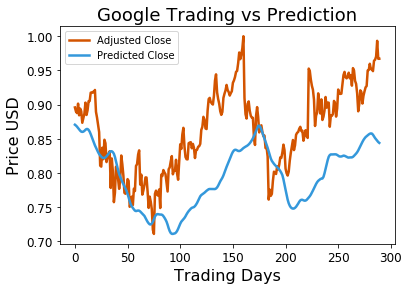

In [62]:
viz.plot_prediction(y_test[:,13], predictions, filename = images_dir+'lstmDeployed.png')

A better way to check how close the test predictions ($\tilde{y}_i$) are to the real target values ($y$), is by calculating the `mean_square_error` (MSE) or the `root_mean_square_error` (RMSE). The lower the numbers, the better the model performance. 

\begin{align*}
\displaystyle MSE &= \frac{1}{n}\sum\limits_{i=1}^n (y_i - \tilde{y_i})^2 \\
\displaystyle RMSE &= (\frac{1}{n}\sum\limits_{i=1}^n (y_i - \tilde{y_i})^2)^{1/2} = \sqrt{MSE}
\end{align*}

In [63]:
from sklearn.metrics import mean_squared_error
import math

score = mean_squared_error(y_test[:,13], predictions)
print("{:<11} {:.8f} MSE ({:.8f} RMSE)".format('Score:', score, math.sqrt(score)))

Score:      0.00677487 MSE (0.08230960 RMSE)


#### 10: Delete the Endpoint

In [64]:
# Delete the predictor endpoint
delete_endpoint(lstm_predictor)

Deleted sagemaker-tensorflow-2019-11-28-23-21-15-840


---

## Delete Endpoints (Optional)
If not already done so, all the endpoints created must be deleted. 

In [65]:
# all the predictors defined in this notebook instance
predictors_created = [linear_predictor, xgb_predictor, lstm_predictor]

for predictor in predictors_created:
    delete_endpoint(predictor)

Already deleted: linear-learner-2019-11-28-22-05-11-012
Already deleted: sagemaker-xgboost-191128-2221-018-25848f47
Already deleted: sagemaker-tensorflow-2019-11-28-23-21-15-840


## Data Cleanup (Optional)
The default notebook instance on SageMaker doesn't have a lot of excess disk space available. Executing notebooks will eventually fill up this disk space, leading to errors which can be difficult to diagnose. It is a good idea to remove the files that was created along the way. Of course, this can be done from the terminal or from the notebook hub as well. The cell below contains some commands to clean up the created files from within the notebook.

In [ ]:
# First we will remove all of the files contained in the data_dir directory
# And then we delete the directory itself
%rm -rf $processed_data_dir/*
%rm -rf $processed_data_dir

%rm -rf $data_dir/*
%rm -rf $data_dir